In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

sns.set(style="whitegrid")
pd.set_option("display.max_columns", 200)

# Load product catalog
products = pd.read_csv("archive/product_info.csv", low_memory=False)
print("products shape:", products.shape)
products.head()


products shape: (8494, 27)


,product_id,product_name,brand_id,brand_name,loves_count,rating,reviews,size,variation_type,variation_value,variation_desc,ingredients,price_usd,value_price_usd,sale_price_usd,limited_edition,new,online_only,out_of_stock,sephora_exclusive,highlights,primary_category,secondary_category,tertiary_category,child_count,child_max_price,child_min_price
0,P473671,Fragrance Discovery Set,6342,19-69,6320,3.6364,11.0,NaN,NaN,NaN,NaN,"['Capri Eau de Parfum:', 'Alcohol Denat. (SD A...",35.0,NaN,NaN,0,0,1,0,0,"['Unisex/ Genderless Scent', 'Warm &Spicy Scen...",Fragrance,Value & Gift Sets,Perfume Gift Sets,0,NaN,NaN
1,P473668,La Habana Eau de Parfum,6342,19-69,3827,4.1538,13.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,NaN,"['Alcohol Denat. (SD Alcohol 39C), Parfum (Fra...",195.0,NaN,NaN,0,0,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,85.0,30.0
2,P473662,Rainbow Bar Eau de Parfum,6342,19-69,3253,4.2500,16.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,NaN,"['Alcohol Denat. (SD Alcohol 39C), Parfum (Fra...",195.0,NaN,NaN,0,0,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0
3,P473660,Kasbah Eau de Parfum,6342,19-69,3018,4.4762,21.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,NaN,"['Alcohol Denat. (SD Alcohol 39C), Parfum (Fra...",195.0,NaN,NaN,0,0,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0
4,P473658,Purple Haze Eau de Parfum,6342,19-69,2691,3.2308,13.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,NaN,"['Alcohol Denat. (SD Alcohol 39C), Parfum (Fra...",195.0,NaN,NaN,0,0,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0


In [17]:
use_cols = [
    "product_id", "product_name", "brand_name",
    "primary_category", "secondary_category",
    "loves_count", "rating", "reviews", "price_usd"
]

df = products[use_cols].copy()

# Convert numeric safely
df["loves_count"] = pd.to_numeric(df["loves_count"], errors="coerce")
df["rating"] = pd.to_numeric(df["rating"], errors="coerce")
df["reviews"] = pd.to_numeric(df["reviews"], errors="coerce")
df["price_usd"] = pd.to_numeric(df["price_usd"], errors="coerce")

# Drop rows missing key measures (rating + loves needed for portfolio)
df = df.dropna(subset=["loves_count", "rating"])

# log transform popularity for skew
df["log_loves"] = np.log1p(df["loves_count"])

print("Rows kept for portfolio:", len(df))
df.head()


Rows kept for portfolio: 8216


,product_id,product_name,brand_name,primary_category,secondary_category,loves_count,rating,reviews,price_usd,log_loves
0,P473671,Fragrance Discovery Set,19-69,Fragrance,Value & Gift Sets,6320,3.6364,11.0,35.0,8.751633
1,P473668,La Habana Eau de Parfum,19-69,Fragrance,Women,3827,4.1538,13.0,195.0,8.250098
2,P473662,Rainbow Bar Eau de Parfum,19-69,Fragrance,Women,3253,4.2500,16.0,195.0,8.087640
3,P473660,Kasbah Eau de Parfum,19-69,Fragrance,Women,3018,4.4762,21.0,195.0,8.012681
4,P473658,Purple Haze Eau de Parfum,19-69,Fragrance,Women,2691,3.2308,13.0,195.0,7.898040


In [19]:
# Median thresholds (robust)
pop_thr = df["log_loves"].median()
rate_thr = df["rating"].median()

df["popularity_level"] = np.where(df["log_loves"] >= pop_thr, "High", "Low")
df["rating_level"] = np.where(df["rating"] >= rate_thr, "High", "Low")

df["segment"] = df["popularity_level"] + " Popularity / " + df["rating_level"] + " Rating"

print("Segment counts:")
print(df["segment"].value_counts())
print(f"\nThresholds: pop_thr(log_loves)={pop_thr:.3f} | rate_thr={rate_thr:.3f}")


Segment counts:
segment
Low Popularity / High Rating     2105
High Popularity / Low Rating     2105
Low Popularity / Low Rating      2003
High Popularity / High Rating    2003
Name: count, dtype: int64

Thresholds: pop_thr(log_loves)=9.254 | rate_thr=4.289


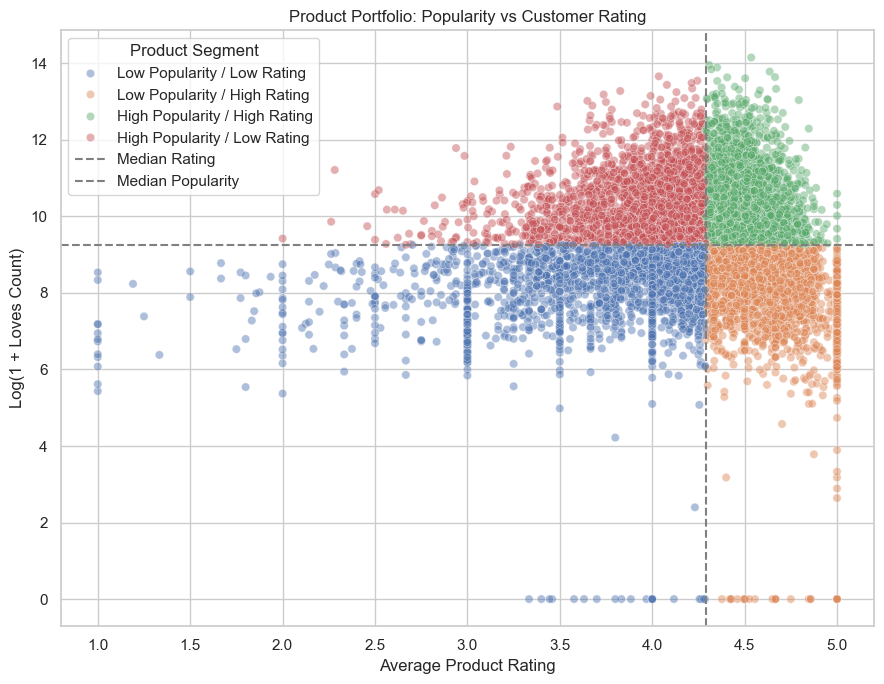

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(9, 7))

sns.scatterplot(
    data=df,
    x="rating",
    y="log_loves",
    hue="segment",
    alpha=0.45
)

plt.axvline(rate_thr, linestyle="--", color="gray", label="Median Rating")
plt.axhline(pop_thr, linestyle="--", color="gray", label="Median Popularity")

plt.title("Product Portfolio: Popularity vs Customer Rating")
plt.xlabel("Average Product Rating")
plt.ylabel("Log(1 + Loves Count)")

plt.legend(title="Product Segment")
plt.tight_layout()
plt.show()


In [25]:
cat = (
    df.groupby("secondary_category")
      .agg(
          products=("product_id", "nunique"),
          median_loves=("loves_count", "median"),
          median_rating=("rating", "median"),
          median_reviews=("reviews", "median")
      )
      .reset_index()
      .sort_values("median_loves", ascending=False)
)

cat.head(15)


,secondary_category,products,median_loves,median_rating,median_reviews
23,Makeup Palettes,20,40164.0,4.57295,186.0
10,Cheek,165,34293.0,4.42390,232.0
20,Lip,407,31262.0,4.33440,213.0
14,Face,653,27278.0,4.21830,364.0
21,Lip Balms & Treatments,61,26121.0,4.26620,277.0
22,Makeup,135,19440.0,4.05000,86.0
12,Eye,694,19298.5,4.15415,260.5
5,Beauty Tools,22,16326.0,4.31365,178.0
33,Shop by Concern,5,14360.0,3.84760,201.0
8,Brushes & Applicators,239,14129.0,4.46880,40.0


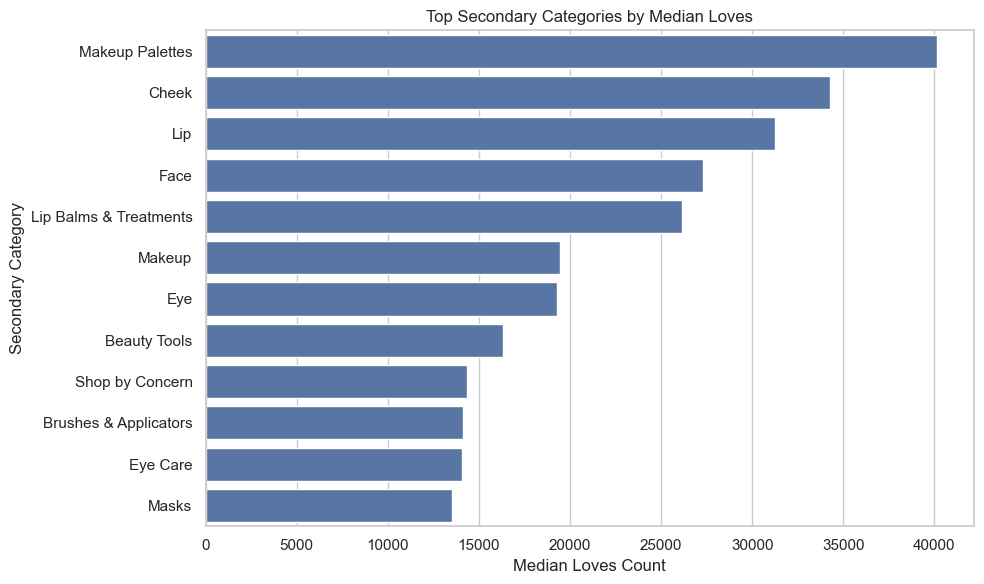

In [26]:
top_cats = cat.head(12)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_cats, y="secondary_category", x="median_loves")
plt.title("Top Secondary Categories by Median Loves")
plt.xlabel("Median Loves Count")
plt.ylabel("Secondary Category")
plt.tight_layout()
plt.show()


In [28]:
hidden_gems = df[df["segment"] == "Low Popularity / High Rating"].copy()

# pick those with at least some review volume so it’s not random noise
hidden_gems = hidden_gems[hidden_gems["reviews"].fillna(0) >= 50]

hidden_gems = hidden_gems.sort_values(["rating", "loves_count"], ascending=False).head(15)

display(hidden_gems[[
    "product_name", "brand_name", "primary_category", "secondary_category",
    "rating", "reviews", "loves_count"
]])


,product_name,brand_name,primary_category,secondary_category,rating,reviews,loves_count
730,Rapid Repair Hair Mask,BondiBoost,Hair,Hair Styling & Treatments,4.9937,158.0,6772
5440,Himalayan Salt & Rosewater Candle,NEST New York,Fragrance,Candles & Home Scents,4.9841,63.0,2304
510,Main Squeeze Beauty Sponge and Cleanser Set,beautyblender,Makeup,Value & Gift Sets,4.9825,57.0,2892
744,Heavenly Hydration Hair Mask,BondiBoost,Hair,Hair Styling & Treatments,4.9818,110.0,1549
8320,Sparkling Cuvee Glass Jar Candle,VOLUSPA,Fragrance,Candles & Home Scents,4.9648,142.0,1829
2474,Youth Reformer Firming Vitamin C Oil Serum,FaceGym,Skincare,Treatments,4.9623,53.0,3104
3146,Splash Salve In-Shower Body Moisture Treatment,Hanni,Bath & Body,Body Moisturizers,4.9623,53.0,2855
737,Blonde Baby Hydrating Toning Purple Conditioner,BondiBoost,Hair,Shampoo & Conditioner,4.9518,228.0,2632
4817,Mini Evening Primrose + Green Tea Algae Retino...,MARA,Skincare,Moisturizers,4.9487,78.0,1039
4818,Evening Primrose + Green Tea Algae Retinol Fac...,MARA,Skincare,Moisturizers,4.9487,78.0,940


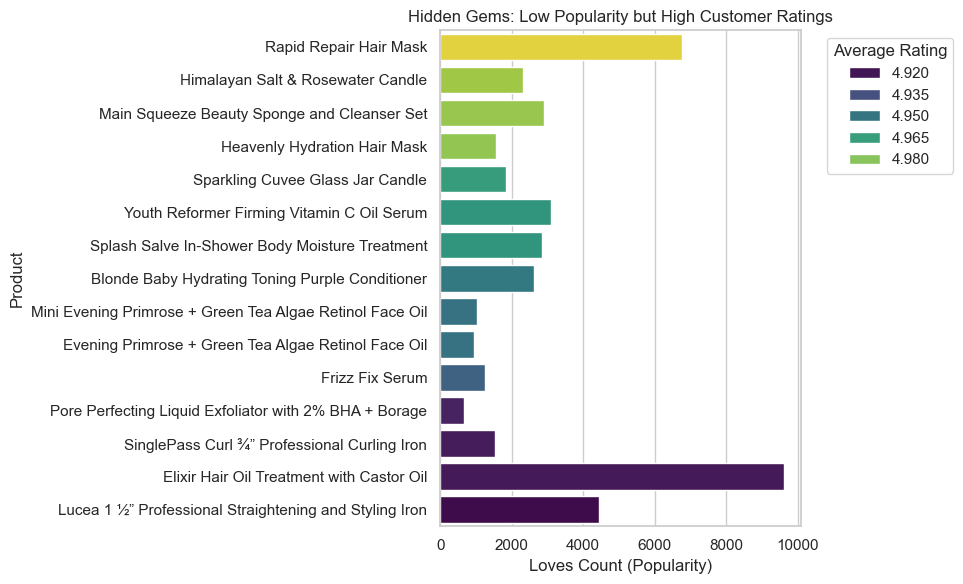

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

sns.barplot(
    data=hidden_gems,
    x="loves_count",
    y="product_name",
    hue="rating",
    dodge=False,
    palette="viridis"
)

plt.title("Hidden Gems: Low Popularity but High Customer Ratings")
plt.xlabel("Loves Count (Popularity)")
plt.ylabel("Product")

# Improve legend
plt.legend(
    title="Average Rating",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)

plt.tight_layout()
plt.show()


In [35]:
# Select only relevant columns for reporting
hidden_gems_export = hidden_gems[
    [
        "product_id",
        "product_name",
        "brand_name",
        "secondary_category",
        "rating",
        "reviews",
        "loves_count"
    ]
].copy()

# Save to CSV
hidden_gems_export.to_csv("hidden_gems_top15.csv", index=False)

print("Saved: hidden_gems_top15.csv")

Saved: hidden_gems_top15.csv
